In [31]:
import pandas as pd
from sklearn.neighbors.regression import KNeighborsRegressor,check_array, _get_weights
from sklearn.neighbors import RadiusNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score


In [32]:
def writer(outfilename,string):
    outfilename.write(string+".\n")


def health_smoothing(df,health,cols,rad=10): #see R2-plotter for documentation
    X=df[cols]
    y=df[health]
    knn= KNeighborsRegressor(n_neighbors=rad).fit(X,y)
    Y=knn.predict(X)
    df[health+'-smooth']=Y
    return df

def add_missing_features_vals(D): #adds missing keys to dictionary D
    L=['commute', 'safety','density','pollution']
    for x in L:
        if x not in D.keys():
            D[x]=0
    return D


def weight_computer(df,outfile,L,report=True):
    #keys for DD are the health features. The values are ordered pairs (features, n_neighbors for KNN)
    DD=({'no-asthma':(['density'],L[0]),
        'sleep >7':(['density','commute'],L[1]),
        'no-obesity':(['commute', 'safety','density'],L[2]),
        'no-mental-health-prob':(['commute', 'safety','density','pollution'],L[3])}) 

    D1=({'no-asthma':'asthma','sleep >7':'sleep',
        'no-obesity':'obesity','no-mental-health-prob':'mental'}) #renaming dictionary
    
    I=[] #list of intercepts
    features=[] #list of dictionaries where each dictionary has the feature as a key and the coiefficient as the value
    linear_regressors={} #dictionary with keys health issue and values  linear regressor objects
    for x in ['no-obesity','no-asthma', 'no-mental-health-prob', 'sleep >7']:
        I.append(D1[x])
        vals={} #coiefficients for regression

        cols,rad=DD[x]

        df_smooth=health_smoothing(df,x,cols,rad) #make smoothed column for health issue x

        smoothed_col=x+"-smooth"
        X=df_smooth[cols]
        y=df_smooth[smoothed_col]

        linreg=LinearRegression().fit(X,y) #fit a linear regression
        linear_regressors[x]=linreg
        Y=linreg.predict(X) #predict Y values from regression
        
        if report:
            #write a report
            writer(outfile,"For "+x+" the features are "+str(DD[x][0])+" and the number of neighbors is "+str(DD[x][1]))
            print("For",x,"the features are ",str(DD[x][0]),"and the number of neighbors is",str(DD[x][1]))

            writer(outfile,"For "+x+" the coiefficients are "+str(linreg.coef_))
            print("For",x,"the coiefficients are",str(linreg.coef_))

            writer(outfile,"For "+x+" the intercept is "+str(linreg.intercept_))
            print("For",x,"the intercept is",str(linreg.intercept_))

            writer(outfile,"For "+x+" the R2 score is "+str(r2_score(Y,y)))
            print("For",x,"the R2 score is",str(r2_score(Y,y)))

            writer(outfile,"For "+x+" the MSE score is "+str(mean_squared_error(Y,y)))
            print("For",x,"the MSE score is",str(mean_squared_error(Y,y)))
            print('')
            writer(outfile,"\n")

        n=len(DD[x][0]) #number of features
        for i in range(n):
            vals[DD[x][0][i]]=linreg.coef_[i] #set key to be i-th feature and value to be i-th coiefficient

        vals=add_missing_features_vals(vals) #make key for other features with value 0

        vals['intercept']=linreg.intercept_ #make an entry for the intercept
        features.append(vals)

    return df,features,linear_regressors

In [33]:
df_main=pd.read_csv("data/normalized-health-and-environmental-train.csv")
model="model1"
run="final-param"
nums=[300,500,900,900] #the number of neighbors to use in smoothing of asthma,sleep,obesity,and mental health, respectively




name="reports/regression-parameters-"+model+"-"+run+".txt"#name of report txt file
outfile=open(name,'w') #open report file

df,F,linear_regressors=weight_computer(df_main,outfile,nums) #outputs dataframe with smoothed columns as well as a dictionary with coiefficients

outfile.close()
a=pd.DataFrame(F,index=['obesity','asthma', 'mental', 'sleep']) #makes a dataframe from the list of dictionaries

a.to_csv("data/weights.csv") 


For no-obesity the features are  ['commute', 'safety', 'density'] and the number of neighbors is 900
For no-obesity the coiefficients are [0.12825307 0.17677874 0.06647973]
For no-obesity the intercept is 53.7113359756564
For no-obesity the R2 score is 0.7014057086887067
For no-obesity the MSE score is 1.2885855533724746

For no-asthma the features are  ['density'] and the number of neighbors is 300
For no-asthma the coiefficients are [-0.02926282]
For no-asthma the intercept is 91.75831238747185
For no-asthma the R2 score is 0.8018766951177511
For no-asthma the MSE score is 0.01696554830127304

For no-mental-health-prob the features are  ['commute', 'safety', 'density', 'pollution'] and the number of neighbors is 900
For no-mental-health-prob the coiefficients are [ 0.03671632  0.04716226 -0.01723103  0.00702343]
For no-mental-health-prob the intercept is 84.0651998527956
For no-mental-health-prob the R2 score is 0.6146561442787238
For no-mental-health-prob the MSE score is 0.12438967

The next cells check how correlated our smoothed outputs are with income. The idea here is to check if our smoothing indeed eliminates the confounding effect of income. We shall see that the smoothing did eliminate most of problems with income.

In [34]:

df_main=pd.read_csv("data/normalized-health-and-environmental-train.csv")
df_env=pd.read_csv("data/normalized-environmental-with-income.csv")
model="model1"
run="final-param"
nums=[300,500,900,900] #the number of neighbors to use in smoothing of asthma,sleep,obesity,and mental health, respectively
outfile=''

a,b,linear_regressor=weight_computer(df_main,outfile,nums,report=False) #outputs dataframe with smoothed columns as well as a dictionary with coiefficients
#here we just want the linear_regressor dictionary for the next cell

DD=({'no-asthma':['density'],
        'sleep >7':['density','commute'],
        'no-obesity':['commute', 'safety','density']})    


In [35]:
for x in DD.keys():
    df_env['predicted-'+x]=linear_regressor[x].predict(df_env[DD[x]])
    X=df_env['predicted-'+x]
    Y=df_env['per-capita-income']
    print("The correlation coiefficient for",x," and per-capita-income is",np.corrcoef(X,Y)[0][1])
    
df_env['HealthScore']=0
for x in DD.keys():
    df_env['HealthScore']=.33*linear_regressor[x].predict(df_env[DD[x]])+df_env['HealthScore']

X=df_env['HealthScore']
Y=df_env['per-capita-income']
print("The correlation coiefficient for equal weight HealthScore and per-capita-income is",np.corrcoef(X,Y)[0][1])

The correlation coiefficient for no-asthma  and per-capita-income is -0.11667111407392303
The correlation coiefficient for sleep >7  and per-capita-income is -0.18049589621493875
The correlation coiefficient for no-obesity  and per-capita-income is 0.1309054563244509
The correlation coiefficient for equal weight HealthScore and per-capita-income is -0.025055433141764612


We here perform some statistical tests on our regression.

In [36]:
import statsmodels.formula.api as smf
    

In [37]:
df_main=df_main.rename({"no-obesity-smooth":"no_obesity_smooth",
                        "no-mental-health-prob-smooth":"no_mental_health_prob_smooth",
                       "no-asthma-smooth":"no_asthma_smooth",
                       "sleep >7-smooth":"sleep_smooth"},axis=1)
df_main.head()

,TractFIPS,no-obesity,sleep >7,no-asthma,no-mental-health-prob,commute,pollution,density,safety,lat,long,no_obesity_smooth,no_asthma_smooth,no_mental_health_prob_smooth,sleep_smooth
0,39049010200,68.6,60.6,90.1,86.3,28.007981,64.0,40.095727,53.395278,39.887363,-82.831037,69.047444,90.492333,87.254000,64.0038
1,6037277000,81.2,69.7,92.9,92.2,32.586751,5.0,51.312922,53.132525,33.971367,-118.400334,70.143000,90.205000,86.985778,63.5082
2,31055006400,69.0,69.6,91.8,89.6,23.482334,21.0,49.132494,51.636690,41.271800,-96.015393,67.790444,90.234333,86.531778,64.1670
3,21067004210,72.7,62.5,90.2,89.5,25.952045,58.0,47.639856,56.034927,37.973347,-84.542794,69.068556,90.317333,87.046778,64.1888
4,6065030700,69.1,61.3,90.6,86.0,26.897005,14.0,51.064463,58.558048,33.967557,-117.388978,71.594000,90.181333,87.048778,63.2048


In [38]:

lm1 = smf.ols(formula='no_obesity_smooth ~ density + commute + safety', data=df_main).fit()
lm1.summary() #this outputs all the relevant details and statistics about the regression


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      no_obesity_smooth   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                 1.516e+04
Date:                Wed, 17 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:06:46   Log-Likelihood:                -21002.
No. Observations:               13587   AIC:                         4.201e+04
Df Residuals:                   13583   BIC:                         4.204e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.7113      0.078    684.828      0.000      53.558      53.865
density        0.0665      0.001     60.533      0.000       0.064       0.069
commute        0.1283      0.001     91.449      0.000       0.126       0.131
safety         0.1768      0.001    178.781      0.000       0.175       0.179
==============================================================================
Omnibus:                     3221.387   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8999.833
Skew:                           1.254   Prob(JB):                         0.00
Kurtosis:                       6.100   Cond. No.                         624.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the Prob(F-statistic) is very small, so we can conclude that our model is better than an intercept only model. Furthermore, each of the features is statistically important.

In [39]:
lm1 = smf.ols(formula='no_mental_health_prob_smooth ~ density + commute + safety+pollution', data=df_main).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     no_mental_health_prob_smooth   R-squared:                       0.722
Model:                                      OLS   Adj. R-squared:                  0.722
Method:                           Least Squares   F-statistic:                     8812.
Date:                          Wed, 17 Jul 2019   Prob (F-statistic):               0.00
Time:                                  12:06:47   Log-Likelihood:                -5119.2
No. Observations:                         13587   AIC:                         1.025e+04
Df Residuals:                             13582   BIC:                         1.029e+04
Df Model:                                     4                                         
Covariance Type:                      nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     84.0652      0.028   2978.550      0.000      84.010      84.121
density       -0.0172      0.000    -45.257      0.000      -0.018      -0.016
commute        0.0367      0.000     82.293      0.000       0.036       0.038
safety         0.0472      0.000    152.153      0.000       0.047       0.048
pollution      0.0070      0.000     42.879      0.000       0.007       0.007
==============================================================================
Omnibus:                      408.562   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.100
Skew:                           0.408   Prob(JB):                    2.03e-100
Kurtosis:                       3.382   Cond. No.                         776.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
lm1 = smf.ols(formula='sleep_smooth ~ density + commute ', data=df_main).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sleep_smooth   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 4.423e+04
Date:                Wed, 17 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:06:47   Log-Likelihood:                -13627.
No. Observations:               13587   AIC:                         2.726e+04
Df Residuals:                   13584   BIC:                         2.728e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     71.6308      0.031   2347.566      0.000      71.571      71.691
density       -0.0733      0.001   -115.332      0.000      -0.075      -0.072
commute       -0.1555      0.001   -191.662      0.000      -0.157      -0.154
==============================================================================
Omnibus:                     1103.330   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6848.894
Skew:                          -0.007   Prob(JB):                         0.00
Kurtosis:                       6.478   Cond. No.                         320.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
lm1 = smf.ols(formula='no_asthma_smooth ~ density', data=df_main).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       no_asthma_smooth   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                 6.857e+04
Date:                Wed, 17 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:06:47   Log-Likelihood:                 8415.1
No. Observations:               13587   AIC:                        -1.683e+04
Df Residuals:                   13585   BIC:                        -1.681e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.7583      0.006   1.61e+04      0.000      91.747      91.769
density       -0.0293      0.000   -261.856      0.000      -0.029      -0.029
==============================================================================
Omnibus:                     3640.608   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16146.380
Skew:                          -1.246   Prob(JB):                         0.00
Kurtosis:                       7.723   Cond. No.                         260.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We finally check our residual plots, to make sure the errors are random. We see that the errors are reasonably random. 


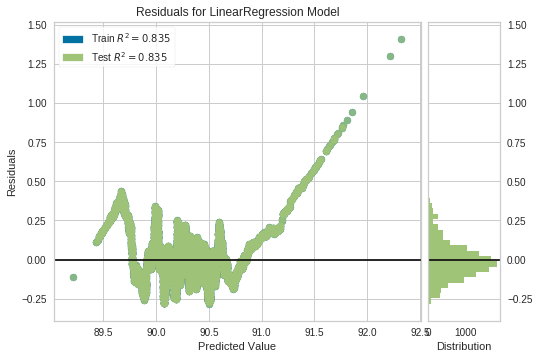

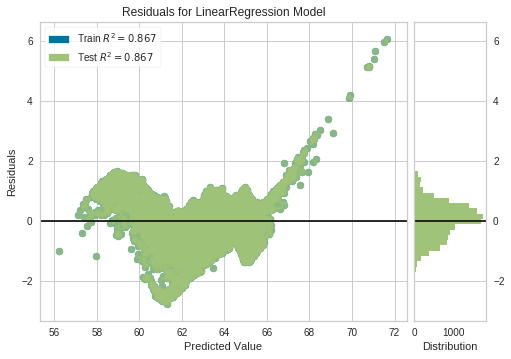

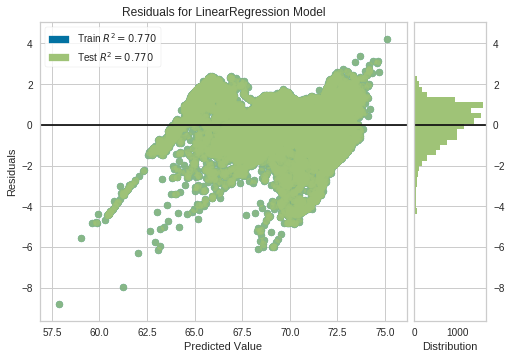

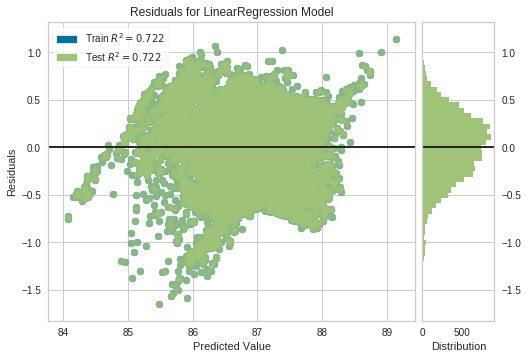

In [42]:

from yellowbrick.regressor import ResidualsPlot

DD=({'no_asthma_smooth':['density'],
        'sleep_smooth':['density','commute'],
        'no_obesity_smooth':['commute', 'safety','density'],
        'no_mental_health_prob_smooth':['commute', 'safety','density','pollution']})
for condition in DD.keys():
    linreg=LinearRegression()
    visualizer = ResidualsPlot(linreg)
    visualizer.fit(df_main[DD[condition]], df_main[condition])  # Fit the training data to the model
    visualizer.score(df_main[DD[condition]], df_main[condition])  # Evaluate the model on the test data
    visualizer.poof()  